# Projet 7 : Proof Of Concept (POC)

L'objectif de ce projet est de faire une veille thématique. Dans le but de monter rapidement en compétences sur des nouveautés en machine learning. La thématique choisie est la super-résoltion. L'idée derrière cette thématique est de voir si l'on peut améliorer le projet sur la classification d'images de chien en augmentant la définition des images.

## Plan
* Augmentation de la définition des images
* Redimensionnement des images
* Visualisation des images
* Approche CNN simple
* Approche Transfer Learning

In [1]:
import os
import shutil
import PIL.Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-aur102pv because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Augmentation de la définition des images

Dans un premier temps on sélectionne 10 classes avec lesquels on va travailler :
* affenpinscher
* boxer
* German_shepherd
* Great_Pyrenees
* pug
* Australian_terrier
* dingo
* golden_retriever
* Irish_wolfhound
* Siberian_husky

On dépose ces images dans le dossier datasets/standard_resolution 
 
Dans un second temps on fait une copie de ce cette arborescence dans datasets/super_resolution

In [4]:
if not os.path.exists('./datasets/super_resolution'):
    shutil.copytree('./datasets/standard_resolution', './datasets/super_resolution')
    !./superes.sh

Ensuite on va appliquer la super-résolution a ces images grâce à l'application realesrgan-ncnn-vulkan téléchargé sur la page github : https://github.com/xinntao/Real-ESRGAN

Un petit script bash a été écrit pour parcourir les fichiers et lancer l'application sur chaque image

```bash
#!/bin/bash

cd datasets/super_resolution

# set -evx
for dir in */; do
    if [ -d "$dir" ]; then
        cd "$dir"
        echo $dir
        for f in *jpg; do
           echo ${f::-4}.png
           ../../../realesrgan-ncnn-vulkan -i $f -o ${f::-4}.png
           rm $f
        done
        cd ..
    fi
done

cd ../..
```



## Redimensionnement des images

In [5]:
def resizeImages(dataset_path, img_size):
    for dir_name in os.listdir(dataset_path):
        dir_path = os.path.join(dataset_path, dir_name)
        for img_name in os.listdir(dir_path):
            img_path = os.path.join(dir_path, img_name)
            print(img_path)
            im = PIL.Image.open(img_path)
            out = im.resize(img_size, resample=PIL.Image.BICUBIC, box=None)
            #save resized image
            out.save(img_path)            


In [6]:
def removeImages(dataset_path):
    for dir_name in os.listdir(dataset_path):
        dir_path = os.path.join(dataset_path, dir_name)
        img_list_ref =  os.listdir(os.path.join('./datasets/standard_resolution_160x160', dir_name))
        for img_name in os.listdir(dir_path):
            img_path = os.path.join(dir_path, img_name)
            img_name_jpg = img_name[:-4] + '.jpg'
            if img_name_jpg not in img_list_ref:
                os.remove(img_path)

In [7]:
if not os.path.exists('./datasets/standard_resolution_160x160'):
    shutil.copytree('./datasets/standard_resolution', './datasets/standard_resolution_160x160')
    resizeImages('./datasets/standard_resolution_160x160', (160,160))
    
if not os.path.exists('./datasets/standard_resolution_640x640'):
    shutil.copytree('./datasets/standard_resolution', './datasets/standard_resolution_640x640')
    resizeImages('./datasets/standard_resolution_640x640', (640,640))
    
if not os.path.exists('./datasets/super_resolution_160x160'):
    shutil.copytree('./datasets/super_resolution', './datasets/super_resolution_160x160')
    resizeImages('./datasets/super_resolution_160x160', (160,160))
    
if not os.path.exists('./datasets/super_resolution_640x640'):
    shutil.copytree('./datasets/super_resolution', './datasets/super_resolution_640x640')
    resizeImages('./datasets/super_resolution_640x640', (640,640))

## Visualisation des images

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory='./datasets/standard_resolution_640x640',
    labels='inferred',
    seed=18)

Found 650 files belonging to 10 classes.


In [9]:
num_classes = len(dataset.class_names)
print(f'Il y a {num_classes} classes de race de chien dans notre dataset')

Il y a 10 classes de race de chien dans notre dataset


On compte le nombre de fichier dans chaque dossier.

In [10]:
list_classes = []
list_size = []

basedir = os.path.abspath('./datasets/standard_resolution_640x640')
for name_class in os.listdir(basedir):
    class_path = os.path.join(basedir, name_class)
    list_classes.append(name_class)
    list_size.append(len(os.listdir(class_path)))

df = pd.DataFrame({'classes':list_classes, 'size':list_size})

On visualise le nombre d'images par races de chien.

<AxesSubplot:xlabel='size', ylabel='classes'>

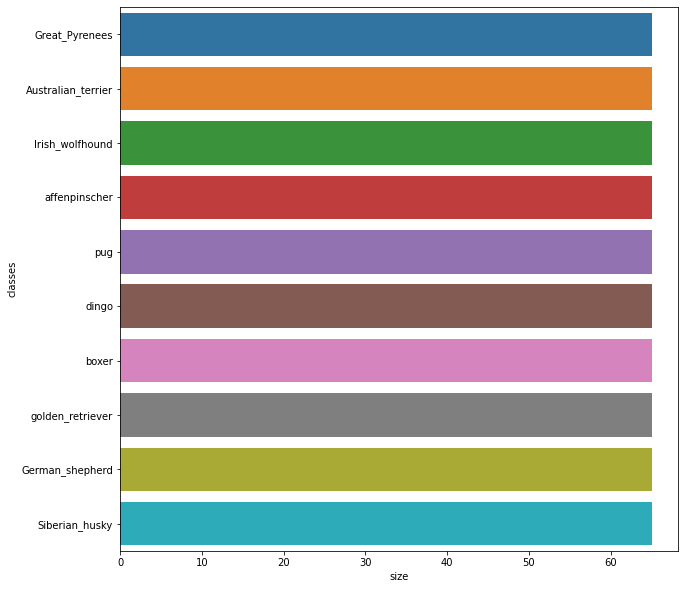

In [11]:
plt.figure(figsize=(10,10))
sns.barplot(x='size', y='classes', data=df)

Quelques images d'exemple du dataset. La méthode take d'un objet tf.data.Dataset permet d'extraire un objet tf.data.Dataset qui correspond à un batch d'images.

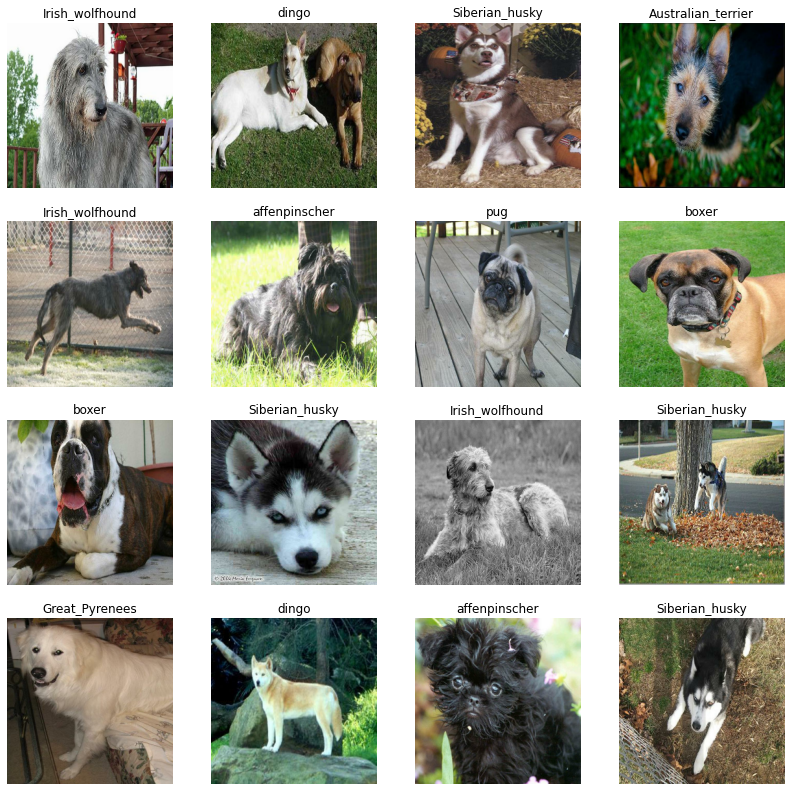

In [12]:
class_names = dataset.class_names

plt.figure(figsize=(14, 14))
for image_list, label_list in dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image_list[i].numpy().astype("uint8"))
    plt.title(class_names[label_list[i]])
    plt.axis("off")

### Sans super-résolution

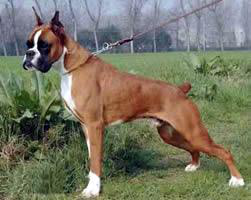

In [13]:
boxer_standard_img = 'datasets/standard_resolution/boxer/n02108089_14112.jpg'
PIL.Image.open(boxer_standard_img)

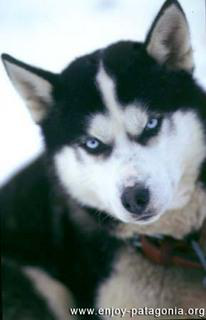

In [14]:
husky_standard_img = 'datasets/standard_resolution/Siberian_husky/n02110185_11626.jpg'
PIL.Image.open(husky_standard_img)

### Avec super-résolution

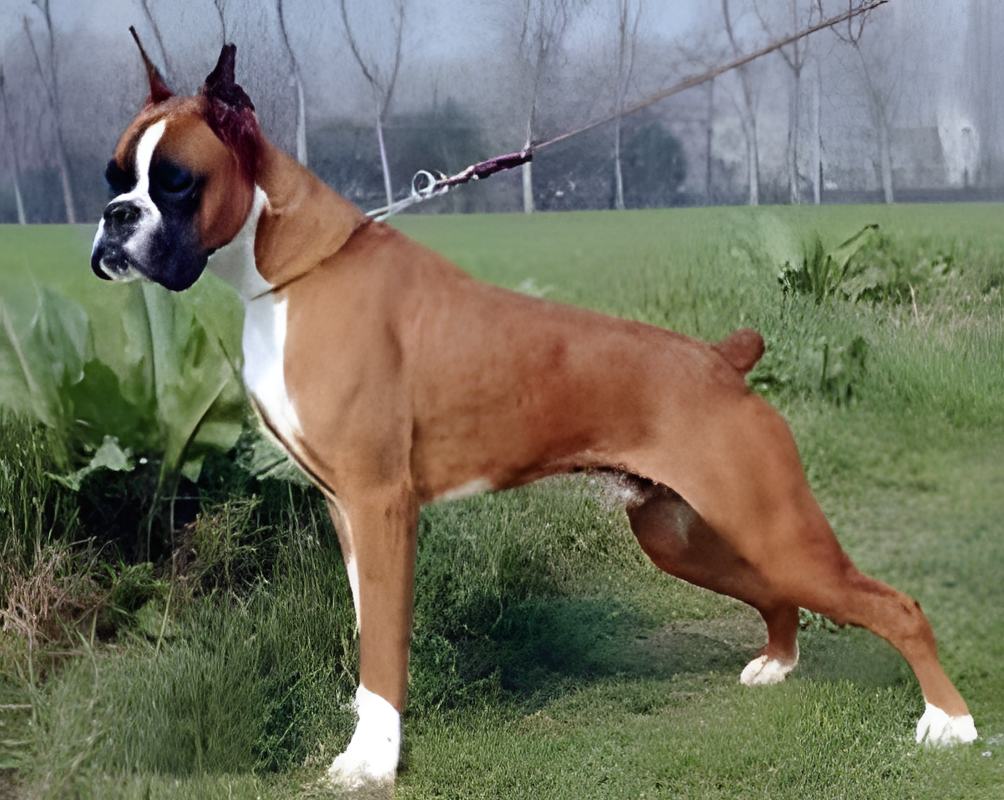

In [15]:
boxer_superes = 'datasets/super_resolution/boxer/n02108089_14112.png'
PIL.Image.open(boxer_superes)

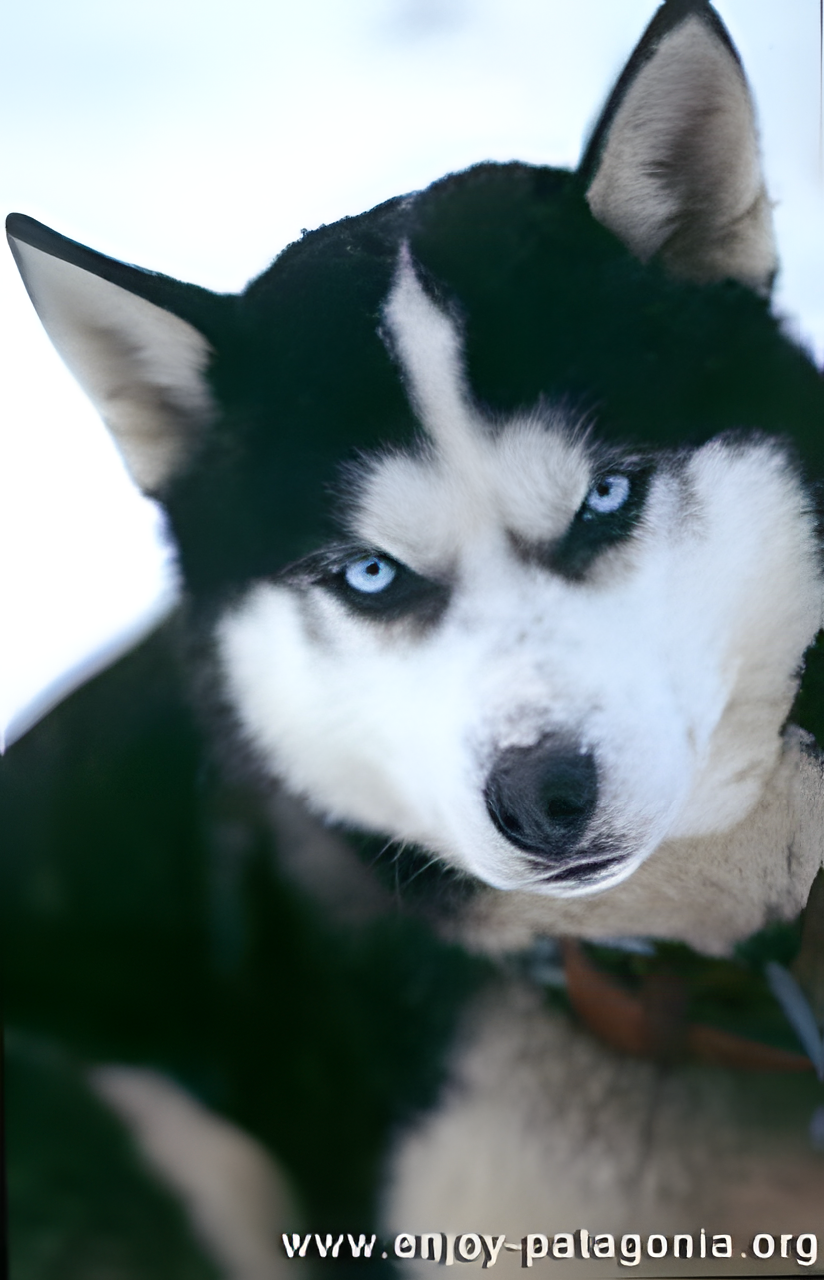

In [16]:
husky_superes = 'datasets/super_resolution/Siberian_husky/n02110185_11626.png'
PIL.Image.open(husky_superes)

## Approche CNN simple

On va définir un modèle CNN simple que l'on va évaluer sur :
* données standard et dimension image petite
* données super-résolution et dimension image petite
* données standard et dimension image grande
* données super-résolution et dimension image grande

In [17]:
results_CNN_path = './results/CNN_simple'
os.makedirs(results_CNN_path, exist_ok=True)

In [18]:
img_size_small = (160, 160)
img_shape_small = (160, 160, 3)
img_size_large = (640, 640)
img_shape_large = (640, 640, 3)

img_path_standard_small = './datasets/standard_resolution_160x160'
img_path_standard_large = './datasets/standard_resolution_640x640'
img_path_superes_small = './datasets/super_resolution_160x160'
img_path_superes_large = './datasets/super_resolution_640x640'

### Définition du TfDataset

In [19]:
def makeDataset(img_path, img_size):

    train_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=img_path,
        labels='inferred',
        label_mode='categorical',
        color_mode='rgb', 
        batch_size=16,
        image_size=img_size,
        shuffle=True,
        seed=42,
        validation_split=0.2,
        subset='training')

    validation_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=img_path,
        labels='inferred',
        label_mode='categorical',
        color_mode='rgb', 
        batch_size=16,
        image_size=img_size,
        shuffle=False,
        seed=42,
        validation_split=0.2,
        subset='validation')
    
    return train_dataset, validation_dataset

### Définition du modèle

In [20]:
def makeModel(img_shape):
    
    rescale_layer = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1./255)])
       
    data_augmentation = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
            tf.keras.layers.experimental.preprocessing.RandomRotation(0.2), 
            tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3)),
            tf.keras.layers.experimental.preprocessing.RandomTranslation(0.3, 0.3, fill_mode='reflect', interpolation='bilinear')])

    model_base = tf.keras.Sequential([
            tf.keras.layers.Conv2D(32, 3, activation='relu'),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Conv2D(32, 3, activation='relu'),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Conv2D(32, 3, activation='relu'),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu')])    
    
    prediction_layer = tf.keras.layers.Dense(10, activation='softmax')
    
    inputs = tf.keras.Input(img_shape)
    rescale = rescale_layer(inputs)
    augmented = data_augmentation(rescale)
    x = model_base(augmented, training=True)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
    
    return model

### Evaluation du model

In [21]:
def evaluateModel(model, train_dataset, validation_dataset, results_path):
    
    os.makedirs(results_path, exist_ok=True)

    if os.path.exists(results_path + 'history.npy'):
        history_dict = np.load(results_path + 'history.npy',allow_pickle='TRUE').item()
    else:
        history = model.fit(
        train_dataset,
        epochs=3000,
        validation_data=validation_dataset)

        history_dict = history.history
        np.save(results_path + 'history.npy',history_dict)
        
    return history_dict

### Standard resolution small images

In [22]:
train_dataset, validation_dataset = makeDataset(img_path_standard_small, img_size_small)

Found 650 files belonging to 10 classes.
Using 520 files for training.
Found 650 files belonging to 10 classes.
Using 130 files for validation.


In [23]:
model_StandardSmall = makeModel(img_shape_small)

In [24]:
history_StandardSmall = evaluateModel(model_StandardSmall, train_dataset, validation_dataset, results_CNN_path + '/StandardSmall/')

### Super resolution small images

In [25]:
train_dataset, validation_dataset = makeDataset(img_path_superes_small, img_size_small)

Found 650 files belonging to 10 classes.
Using 520 files for training.
Found 650 files belonging to 10 classes.
Using 130 files for validation.


In [26]:
model_SuperesSmall = makeModel(img_shape_small)

In [27]:
history_SuperesSmall = evaluateModel(model_SuperesSmall, train_dataset, validation_dataset, results_CNN_path + '/SuperesSmall/')

### Standard resolution large images

In [28]:
train_dataset, validation_dataset = makeDataset(img_path_standard_large, img_size_large)

Found 650 files belonging to 10 classes.
Using 520 files for training.
Found 650 files belonging to 10 classes.
Using 130 files for validation.


In [29]:
model_StandardLarge = makeModel(img_shape_large)

In [30]:
history_StandardLarge = evaluateModel(model_StandardLarge, train_dataset, validation_dataset, results_CNN_path + '/StandardLarge/')

### Super resolution large images

In [31]:
train_dataset, validation_dataset = makeDataset(img_path_superes_large, img_size_large)

Found 650 files belonging to 10 classes.
Using 520 files for training.
Found 650 files belonging to 10 classes.
Using 130 files for validation.


In [32]:
model_SuperesLarge = makeModel(img_shape_large)

In [33]:
history_SuperesLarge = evaluateModel(model_SuperesLarge, train_dataset, validation_dataset, results_CNN_path + '/SuperesLarge/')

### Comparaison

In [34]:
val_acc = pd.DataFrame({'StandardSmall':history_StandardSmall['val_accuracy'],
                        'SuperesSmall':history_SuperesSmall['val_accuracy'],
                        'StandardLarge':history_StandardLarge['val_accuracy'],
                        'SuperesLarge':history_SuperesLarge['val_accuracy']})

In [35]:
val_loss = pd.DataFrame({'StandardSmall':history_StandardSmall['val_loss'],
                         'SuperesSmall':history_SuperesSmall['val_loss'],
                         'StandardLarge':history_StandardLarge['val_loss'],
                         'SuperesLarge':history_SuperesLarge['val_loss']})

In [36]:
def plotResults(df_results, llimit, ulimit, slidind_window, ylabel, title):
    palette = sns.color_palette(None, 4)
    plt.plot(df_results.loc[llimit:ulimit, 'StandardSmall'], color=palette[0], alpha=0.2)
    plt.plot(df_results.loc[llimit:ulimit, 'SuperesSmall'], color=palette[1], alpha=0.2)
    plt.plot(df_results.loc[llimit:ulimit, 'StandardLarge'], color=palette[2], alpha=0.2)
    plt.plot(df_results.loc[llimit:ulimit, 'SuperesLarge'], color=palette[3], alpha=0.2)
    
    plt.plot(df_results.loc[llimit:ulimit, 'StandardSmall'].rolling(slidind_window).mean(), color=palette[0], label='StandardSmall')
    plt.plot(df_results.loc[llimit:ulimit, 'SuperesSmall'].rolling(slidind_window).mean(), color=palette[1], label='SuperesSmall')
    plt.plot(df_results.loc[llimit:ulimit, 'StandardLarge'].rolling(slidind_window).mean(), color=palette[2], label='StandardLarge') 
    plt.plot(df_results.loc[llimit:ulimit, 'SuperesLarge'].rolling(slidind_window).mean(), color=palette[3], label='SuperesLarge')

    plt.ylabel(ylabel)
    plt.xlabel('epoch')
    plt.title(title)
    plt.legend()

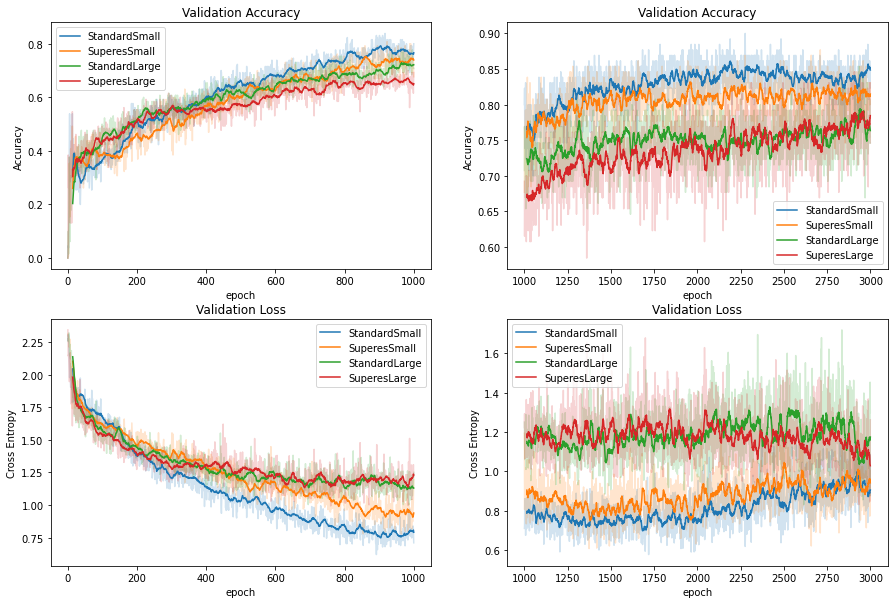

In [37]:
slidind_window = 15
lm = 1000

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plotResults(val_acc, 0, lm, slidind_window, 'Accuracy', 'Validation Accuracy')
plt.subplot(2, 2, 2)
plotResults(val_acc, lm, 3000, slidind_window, 'Accuracy', 'Validation Accuracy')

plt.subplot(2, 2, 3)
plotResults(val_loss, 0, lm, slidind_window, 'Cross Entropy', 'Validation Loss')
plt.subplot(2, 2, 4)
plotResults(val_loss, lm, 3000, slidind_window, 'Cross Entropy', 'Validation Loss')

plt.show()

## Approche Transfer Learning

On va définir un modèle utilisant le Transfer Learning que l'on va évaluer sur :
* données standard et dimension image petite
* données super-résolution et dimension image petite
* données standard et dimension image grande
* données super-résolution et dimension image grande

Dans le projet précedent on a montrer que le modèle DenseNet201 permettait d'avoir les meilleurs résultats en utilisant une taille d'image 160x160. Une optimisation a permis de déterminer la meilleure architecture à la suite de ce modèle.

La meilleur architecture obtenue a été :
* DenseNet201 sans la dernière couche
* couche de dropout de 0.4
* couche dense de 672 neurones
* couche de prédiction de 120 neurones (car 120 classes sur le projet précédent)

Avec learning rate de 1e-4

On va repartir de ce modèle pour faire notre comparaison. On va juste changer la couche de prédiction pour une couche dense de 10 neurones car 10 classes.

In [38]:
results_TF_path = './results/TF'
os.makedirs(results_TF_path, exist_ok=True)

### Définition du TfDataset

In [39]:
def makeTFDataset(img_path, img_size):

   train_dataset = tf.keras.utils.image_dataset_from_directory(
       directory=img_path,
       labels='inferred',
       label_mode='categorical',
       color_mode='rgb', 
       batch_size=16,
       image_size=img_size,
       shuffle=True,
       seed=42,
       validation_split=0.2,
       subset='training')

   validation_dataset = tf.keras.utils.image_dataset_from_directory(
       directory=img_path,
       labels='inferred',
       label_mode='categorical',
       color_mode='rgb', 
       batch_size=16,
       image_size=img_size,
       shuffle=False,
       seed=42,
       validation_split=0.2,
       subset='validation')
   
   return train_dataset, validation_dataset

### Définition du modèle

In [40]:
def makeTFModel(img_shape):
      
   model_kwargs = dict(
       include_top=False,
       weights='imagenet',
       input_tensor=None,
       input_shape=img_shape,
       pooling=None,
       classes=1000)
   
   base_model = tf.keras.applications.densenet.DenseNet201(**model_kwargs)
   base_model.trainable = False
   base_model.summary()
      
   data_augmentation = tf.keras.Sequential([
           tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
           tf.keras.layers.experimental.preprocessing.RandomRotation(0.2), 
           tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3)),
           tf.keras.layers.experimental.preprocessing.RandomTranslation(0.3, 0.3, fill_mode='reflect', interpolation='bilinear')])

   
   global_avg_layer = tf.keras.layers.GlobalAveragePooling2D()
   prediction_layer = tf.keras.layers.Dense(10, activation='softmax')
   
   inputs = tf.keras.Input(img_shape)
   prepro = tf.keras.applications.densenet.preprocess_input(inputs)
   augmented = data_augmentation(prepro)    
   x = base_model(augmented, training=False)
   x = global_avg_layer(x)
   x = tf.keras.layers.Dropout(0.4)(x)
   x = tf.keras.layers.Dense(672, activation='relu')(x)
   outputs = prediction_layer(x)
   model = tf.keras.Model(inputs, outputs)
   
   model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
             loss=tf.keras.losses.CategoricalCrossentropy(),
             metrics=['accuracy'])
   
   return model

### Evaluation du model

In [41]:
def evaluateTFModel(model, train_dataset, validation_dataset, results_path):
    
    os.makedirs(results_path, exist_ok=True)

    if os.path.exists(results_path + 'history.npy'):
        history_dict = np.load(results_path + 'history.npy',allow_pickle='TRUE').item()
    else:
        history = model.fit(
        train_dataset,
        epochs=100,
        validation_data=validation_dataset)

        history_dict = history.history
        np.save(results_path + 'history.npy',history_dict)
        
    return history_dict

### Standard resolution small images

In [42]:
train_dataset, validation_dataset = makeTFDataset(img_path_standard_small, img_size_small)

Found 650 files belonging to 10 classes.
Using 520 files for training.
Found 650 files belonging to 10 classes.
Using 130 files for validation.


In [43]:
model_StandardSmall = makeTFModel(img_shape_small)

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 166, 166, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 80, 80, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 80, 80, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [44]:
history_StandardSmall = evaluateTFModel(model_StandardSmall, train_dataset, validation_dataset, results_TF_path + '/StandardSmall/')

### Super resolution small images

In [45]:
train_dataset, validation_dataset = makeTFDataset(img_path_superes_small, img_size_small)

Found 650 files belonging to 10 classes.
Using 520 files for training.
Found 650 files belonging to 10 classes.
Using 130 files for validation.


In [46]:
model_SuperesSmall = makeTFModel(img_shape_small)

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 166, 166, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 80, 80, 64)   9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 80, 80, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

conv5_block25_0_bn (BatchNormal (None, 5, 5, 1664)   6656        conv5_block24_concat[0][0]       
__________________________________________________________________________________________________
conv5_block25_0_relu (Activatio (None, 5, 5, 1664)   0           conv5_block25_0_bn[0][0]         
__________________________________________________________________________________________________
conv5_block25_1_conv (Conv2D)   (None, 5, 5, 128)    212992      conv5_block25_0_relu[0][0]       
__________________________________________________________________________________________________
conv5_block25_1_bn (BatchNormal (None, 5, 5, 128)    512         conv5_block25_1_conv[0][0]       
__________________________________________________________________________________________________
conv5_block25_1_relu (Activatio (None, 5, 5, 128)    0           conv5_block25_1_bn[0][0]         
__________________________________________________________________________________________________
conv5_bloc

In [47]:
history_SuperesSmall = evaluateTFModel(model_SuperesSmall, train_dataset, validation_dataset, results_TF_path + '/SuperesSmall/')

### Standard resolution large images

In [48]:
train_dataset, validation_dataset = makeTFDataset(img_path_standard_large, img_size_large)

Found 650 files belonging to 10 classes.
Using 520 files for training.
Found 650 files belonging to 10 classes.
Using 130 files for validation.


In [49]:
model_StandardLarge = makeTFModel(img_shape_large)

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 640, 640, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 646, 646, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 320, 320, 64) 9408        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 320, 320, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

Total params: 18,321,984
Trainable params: 0
Non-trainable params: 18,321,984
__________________________________________________________________________________________________


In [50]:
history_StandardLarge = evaluateTFModel(model_StandardLarge, train_dataset, validation_dataset, results_TF_path + '/StandardLarge/')

### Super resolution large images

In [51]:
train_dataset, validation_dataset = makeTFDataset(img_path_superes_large, img_size_large)

Found 650 files belonging to 10 classes.
Using 520 files for training.
Found 650 files belonging to 10 classes.
Using 130 files for validation.


In [52]:
model_SuperesLarge = makeTFModel(img_shape_large)

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 640, 640, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 646, 646, 3)  0           input_11[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 320, 320, 64) 9408        zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 320, 320, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

Total params: 18,321,984
Trainable params: 0
Non-trainable params: 18,321,984
__________________________________________________________________________________________________


In [53]:
history_SuperesLarge = evaluateTFModel(model_SuperesLarge, train_dataset, validation_dataset, results_TF_path + '/SuperesLarge/')

### Comparaison

In [54]:
val_acc = pd.DataFrame({'StandardSmall':history_StandardSmall['val_accuracy'],
                        'SuperesSmall':history_SuperesSmall['val_accuracy'],
                        'StandardLarge':history_StandardLarge['val_accuracy'],
                        'SuperesLarge':history_SuperesLarge['val_accuracy']})

In [55]:
val_loss = pd.DataFrame({'StandardSmall':history_StandardSmall['val_loss'],
                         'SuperesSmall':history_SuperesSmall['val_loss'],
                         'StandardLarge':history_StandardLarge['val_loss'],
                         'SuperesLarge':history_SuperesLarge['val_loss']})

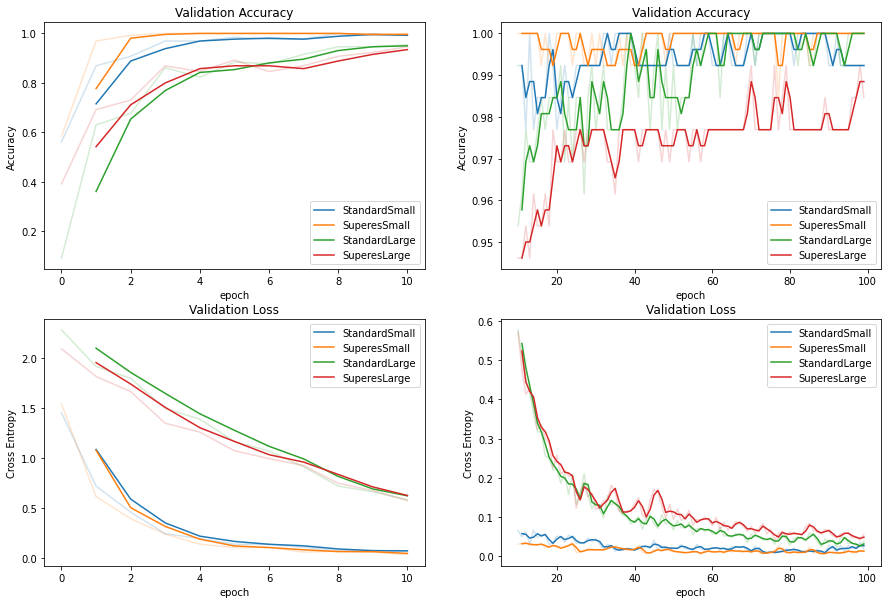

In [56]:
slidind_window = 2
lm = 10

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plotResults(val_acc, 0, lm, slidind_window, 'Accuracy', 'Validation Accuracy')
plt.subplot(2, 2, 2)
plotResults(val_acc, lm, 100, slidind_window, 'Accuracy', 'Validation Accuracy')

plt.subplot(2, 2, 3)
plotResults(val_loss, 0, lm, slidind_window, 'Cross Entropy', 'Validation Loss')
plt.subplot(2, 2, 4)
plotResults(val_loss, lm, 100, slidind_window, 'Cross Entropy', 'Validation Loss')

plt.show()